# Encodings

We want to review the encoding schema especially with concern to the geo-location

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Add the parent directory to the path
import sys  
sys.path.insert(1, '../')

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from model.encoding import PositionalEncoding, GeoEncoding

## Setup Encoders

In [145]:
p_enc = PositionalEncoding(
    d_model=256,
    width=224 // 16,
    height=224 // 16)

g_enc = GeoEncoding(
    g_model=32,
    d_model=256,
    width=224 // 16,
    height=224 // 16)

## Review Base Encoding

In [75]:
fixed_enc = p_enc.pe.detach().numpy()

In [76]:
fixed_enc.shape

(1, 196, 256)

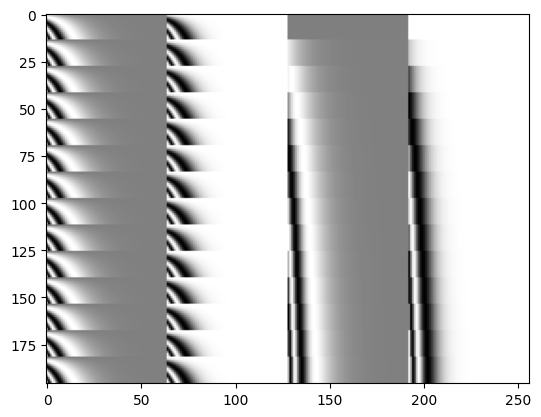

In [96]:
plt.imshow(fixed_enc[0], cmap='gray')

This is a correct encoding where we see the patterns on the right for the x, y coordinates embedding and on the right is the encoding offset for the patch

## Review Geo Encoding

In [98]:
sample = torch.zeros((1, 196, 256)) # this is the shape of the input to encoding once patch embedding is complete

In [158]:
def plot_encodings(locs, rows, cols, figsize):
    _, axs = plt.subplots(rows, cols, figsize=figsize)

    for i, loc in enumerate(locs):
        ax = axs[i // cols, i % cols]

        geo_enc = g_enc.get_pe(sample, loc)
        ax.imshow(geo_enc[0], cmap='gray')
        ax.axis('off')

        loc_str = f'({loc[0][0]}, {loc[0][1]})'
        ax.set_title(loc_str)

    axs[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()

In [123]:
key_loc = torch.from_numpy(np.array([
    [[0.0, 0.0]],
    [[180.0, 0.0]],
    [[0.0, 180.0]],
    [[-180.0, 0.0]],
    [[0.0, -180.0]],
    [[180.0, 180.0]],
    [[-180.0, -180.0]],
]))

close_loc = torch.from_numpy(np.array([
    [[75.0, 75.0]],
    [[75.0, 75.1]],
    [[75.1, 75.0]],
    [[75.1, 75.1]]
]))

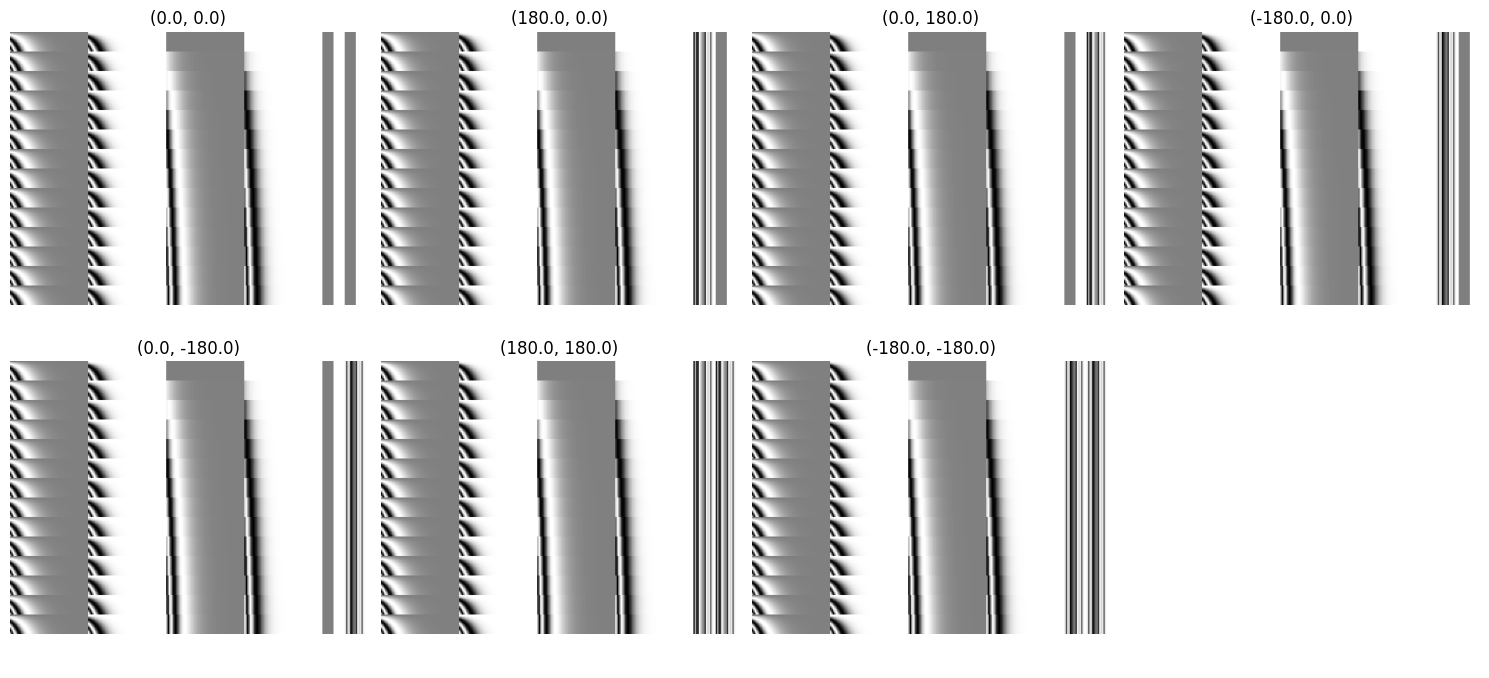

In [159]:
plot_encodings(key_loc, 2, 4, (15, 7))

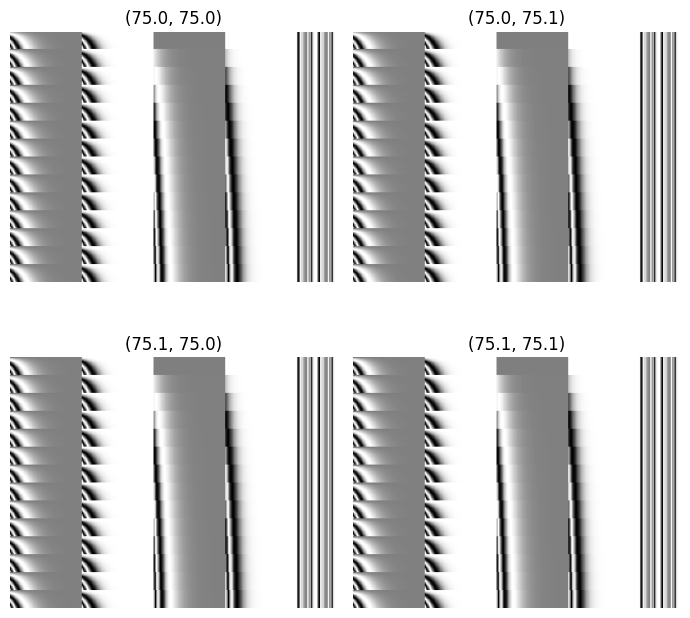

In [162]:
plot_encodings(close_loc, 2, 2, (7, 7))

In [148]:
first = close_loc[0]
first_enc = g_enc.get_pe(sample, first)

for loc in close_loc[1:]:
    loc_enc = g_enc.get_pe(sample, loc)
    print(f'{first.numpy()} -> {loc.numpy()}', torch.allclose(first_enc, loc_enc))

[[75. 75.]] -> [[75.  75.1]] False
[[75. 75.]] -> [[75.1 75. ]] False
[[75. 75.]] -> [[75.1 75.1]] False


Although hard to see discrepencies at the end of the locational embeddings they do seem to vary even at very close points

In [178]:
def plot_geo_encodings(locs, rows, cols, figsize):
    _, axs = plt.subplots(rows, cols, figsize=figsize)

    for i, loc in enumerate(locs):
        ax = axs[i // cols, i % cols]

        geo_enc = torch.cat([
            g_enc._positional_encoding_1d(8, loc[:, 0]),
            g_enc._positional_encoding_1d(8, loc[:, 1])
        ], dim=1)

        ax.imshow(geo_enc, cmap='gray')
        ax.axis('off')

        loc_str = f'({loc[0][0]:0.3f}, {loc[0][1]:0.3f})'
        ax.set_title(loc_str)

    axs[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()

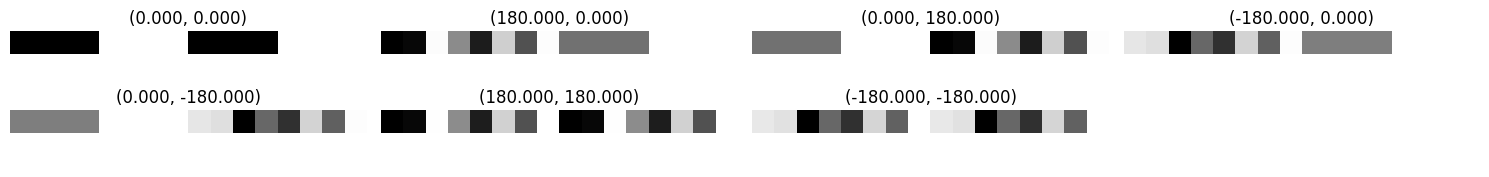

In [184]:
plot_geo_encodings(key_loc, 2, 4, figsize=(15, 2))

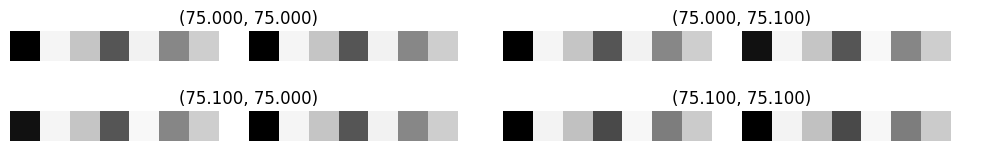

In [183]:
plot_geo_encodings(close_loc, 2, 2, figsize=(10, 2))

## Test Boundary Adjustment

The original bounds are $(-180, 180)$ what happens if we scale it to $(0, 360)$ or $(0, 1)$

### (0, 360)

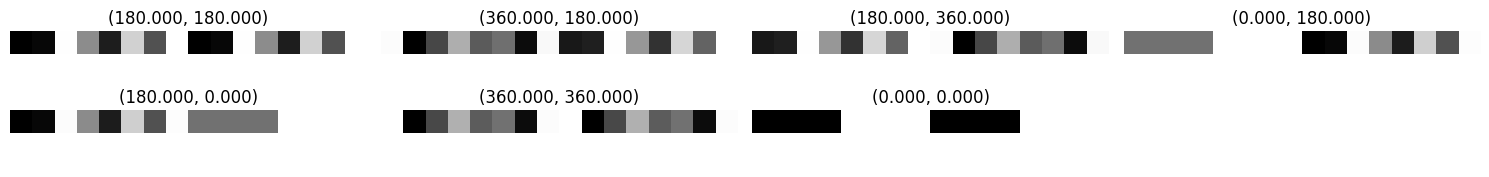

In [181]:
plot_geo_encodings(key_loc + 180, 2, 4, figsize=(15, 2))

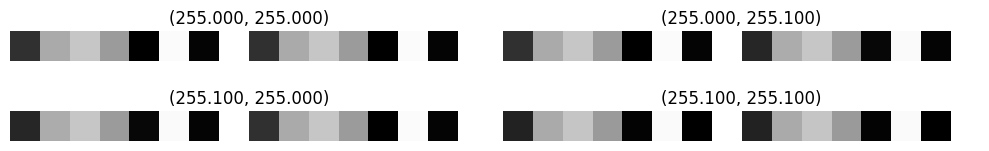

In [182]:
plot_geo_encodings(close_loc + 180, 2, 2, figsize=(10, 2))

### (0, 1)

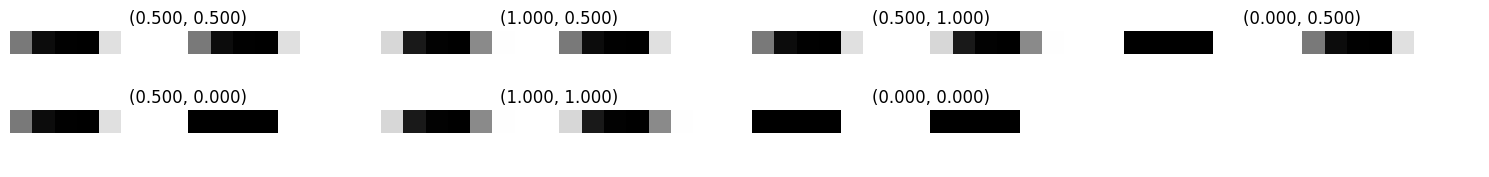

In [180]:
plot_geo_encodings((key_loc + 180) / 360, 2, 4, figsize=(15, 2))

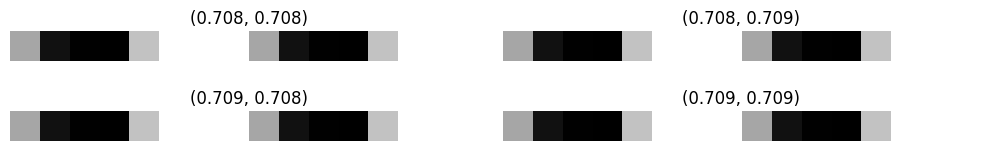

In [179]:
plot_geo_encodings((close_loc + 180) / 360, 2, 2, figsize=(10, 2))

## Tile Id Encoding

In [202]:
tile_id = torch.from_numpy(np.array([
    [[1, 1]],
    [[2, 7]],
    [[7, 2]],
    [[16, 10]],
    [[18, 19]]
]))

locs = torch.from_numpy(np.array([
    [[-124, 40]],
    [[-142, 20]],
    [[30, -110]],
    [[90, -90]],
    [[110, -10]]
]))

In [203]:
loc = locs[0]
tile = tile_id[-2]

geo_enc = torch.cat([
    g_enc._positional_encoding_1d(8, loc[:, 0]),
    g_enc._positional_encoding_1d(8, loc[:, 1]),
    g_enc._positional_encoding_1d(8, tile[:, 0]),
    g_enc._positional_encoding_1d(8, tile[:, 1])
], dim=1)

In [204]:
geo_enc

tensor([[ 0.9957,  0.1656, -0.9458, -0.1237, -0.0928,  0.9862,  0.3248,  0.9923,
          0.7451, -0.7568,  0.3894,  0.0400, -0.6669, -0.6536,  0.9211,  0.9992,
         -0.2879,  0.9996,  0.1593,  0.0160, -0.9577, -0.0292,  0.9872,  0.9999,
         -0.5440,  0.8415,  0.0998,  0.0100, -0.8391,  0.5403,  0.9950,  0.9999]])

## Exploring Date + Geo Encodings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def positional_encoding_1d(embed_dim: int,
                           pos: np.array,
                           temperature: float = 10_000.0) -> np.array:
    pos = pos.reshape(-1)

    omega = np.arange(embed_dim // 2, dtype=float)
    omega = 1.0 / temperature ** (omega / (embed_dim / 2))

    pos = np.outer(pos, omega)

    embed = np.concatenate([
        np.sin(pos),
        np.cos(pos)
    ], axis=-1)

    return embed

In [38]:
month_encodings_encode = positional_encoding_1d(
    embed_dim=128,
    pos=np.array([i for i in range(0, 12)])
)

month_encodings_decode = positional_encoding_1d(
    embed_dim=64,
    pos=np.array([i for i in range(0, 12)])
)

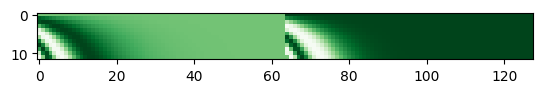

In [47]:
plt.imshow(
    month_encodings_encode,
    cmap='Greens'
)

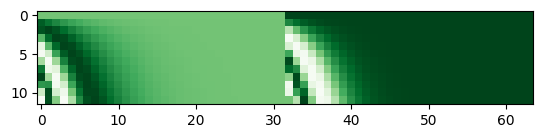

In [48]:
plt.imshow(
    month_encodings_decode,
    cmap='Greens'
)

In [42]:
base_year = 1930
max_year = 1971
year_range = max_year - base_year

year_encodings_encode = positional_encoding_1d(
    embed_dim=128,
    pos=np.array([i for i in range(0, year_range)])
)

year_encodings_decode = positional_encoding_1d(
    embed_dim=64,
    pos=np.array([i for i in range(0, year_range)])
)

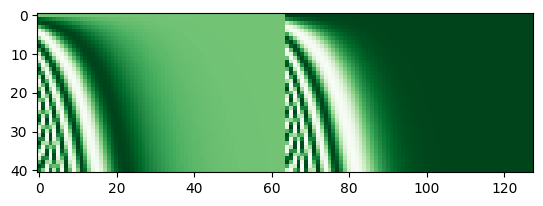

In [43]:
plt.imshow(
    year_encodings_encode,
    cmap='Greens'
)

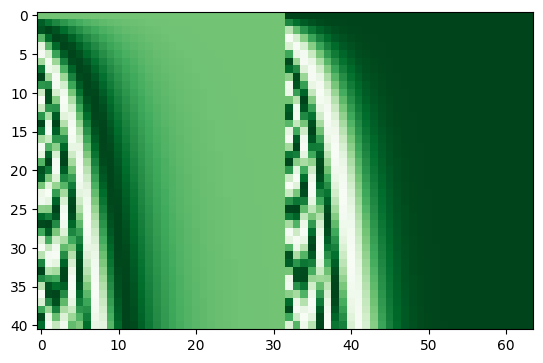

In [44]:
plt.imshow(
    year_encodings_decode,
    cmap='Greens'
)

In [49]:
base_z = 6000
max_z = 50_000
z_range = (max_z - base_z) // 1000

pos_z_encodings_encode = positional_encoding_1d(
    embed_dim=128,
    pos=np.array([i for i in range(0, z_range)])
)

pos_z_encodings_decode = positional_encoding_1d(
    embed_dim=64,
    pos=np.array([i for i in range(0, z_range)])
)

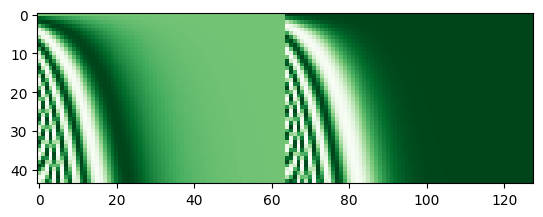

In [50]:
plt.imshow(
    pos_z_encodings_encode,
    cmap='Greens'
)

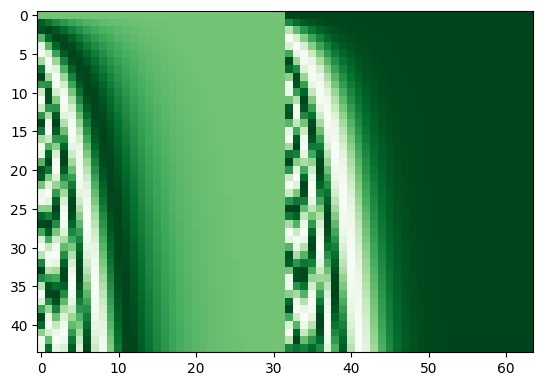

In [51]:
plt.imshow(
    pos_z_encodings_decode,
    cmap='Greens'
)

In [59]:
long_st = -180
long_en = 180

pos_x_encodings_encode = positional_encoding_1d(
    embed_dim=128,
    pos=np.array([i for i in range(long_st, long_en)])
)

pos_x_encodings_decode = positional_encoding_1d(
    embed_dim=64,
    pos=np.array([i for i in range(long_st, long_en)])
)

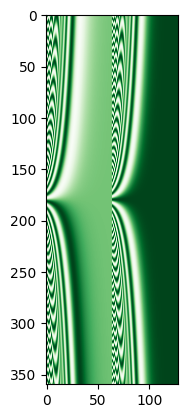

In [60]:
plt.imshow(
    pos_x_encodings_encode,
    cmap='Greens'
)

In [61]:
lat_st = -90
lat_en = 90

pos_y_encodings_encode = positional_encoding_1d(
    embed_dim=128,
    pos=np.array([i for i in range(lat_st, lat_en)])
)

pos_y_encodings_decode = positional_encoding_1d(
    embed_dim=64,
    pos=np.array([i for i in range(lat_st, lat_en)])
)

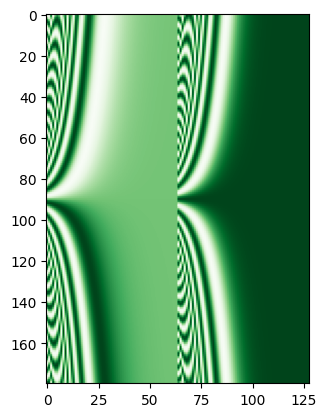

In [62]:
plt.imshow(
    pos_y_encodings_encode,
    cmap='Greens'
)

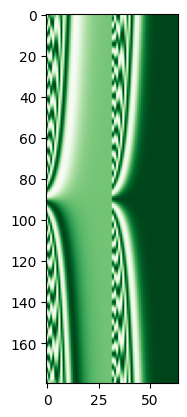

In [63]:
plt.imshow(
    pos_y_encodings_decode,
    cmap='Greens'
)

Seems unable to differentiate at this fine a scale, so if x, y are only concerned with larger movements than this is okay

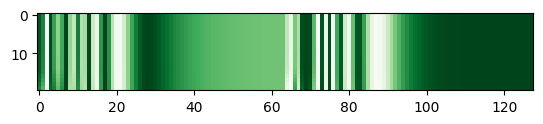

In [68]:
pos_y_smallmove_encodings = positional_encoding_1d(
    embed_dim=128,
    pos=np.array([
        90.0001,
        90.0002,
        90.0003,
        90.0004,
        90.0005,
        90.0010,
        90.0020,
        90.0030,
        90.0040,
        90.0050,
        90.0100,
        90.0200,
        90.0300,
        90.0400,
        90.0500,
        90.1000,
        90.2000,  
        90.3000,
        90.4000,
        90.5000
    ])
)

plt.imshow(
    pos_y_smallmove_encodings,
    cmap='Greens'
)

## Encoding size requirements

For our purposes the date is more useful in terms of the year since it can affect the image quality.
So taking the year and then a form of x, y, z geo locational references leads us to 4 encoded fields.
If using the same dimensionality as SatMAE it would require 512 of the positional encoding allotment meaning at the least we need to bump encoding up to 1024 at 768 almost the entire encoding budget would be spent on the additional meta data.

In [66]:
# from encode perspective
4 * 128

512

In [67]:
# from decode perspective
4 * 64

256